In [41]:
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.linalg import svd
from skimage import exposure
import cv2

In [3]:
two_lights = scipy.io.loadmat("illuminant_separation/data/images/two_lights/book.mat")
reflectance_illum_camera = scipy.io.loadmat("illuminant_separation/data/reflectance_illum_camera.mat")

In [4]:
def plot_spectrum(spectrum, title, spectrum_type):
    # wavelengths from 380 - 780 nm
    wavelengths = np.linspace(380, 780, 101)
    plt.figure(figsize=(8, 4))
    plt.plot(wavelengths, spectrum, 'b-', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.xlabel('Wavelength (nm)')
    if spectrum_type == 'reflectance':
        plt.ylabel('Reflectance')
        plt.ylim([0, 1])
    else:
        plt.ylabel('Illumination')
        plt.ylim([0, plt.ylim()[1]])

    plt.title(title)
    plt.xticks(np.arange(380, 781, 50))

    # Add vertical lines for RGB peak sensitivities (approximately)
    rgb_peaks = [450, 550, 600]  # Blue, Green, Red approximate peaks
    colors = ['blue', 'green', 'red']
    for peak, color in zip(rgb_peaks, colors):
        plt.axvline(x=peak, color=color, linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_camera_response(camera_response):
    assert camera_response.shape[0]== 3
    R,G,B = camera_response

    wavelengths = np.linspace(380, 780, R.shape[0])
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, R, 'r-', linewidth=2)
    plt.plot(wavelengths, G, 'g-', linewidth=2)
    plt.plot(wavelengths, B, 'b-', linewidth=2)

    plt.legend(['Red', 'Green', 'Blue'], loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Wavelength (nm)')
    plt.title("Camera Response Function")
    plt.xticks(np.arange(380, 781, 50))

    # Add vertical lines for RGB peak sensitivities (approximately)
    rgb_peaks = [450, 550, 600]  # Blue, Green, Red approximate peaks
    colors = ['blue', 'green', 'red']
    for peak, color in zip(rgb_peaks, colors):
        plt.axvline(x=peak, color=color, linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
def to_8bit(img): 
    min_i = img.min()
    max_i = img.max()
    img = (img - min_i)/(max_i - min_i)
    return (255 * img).astype(np.uint8)

def contrast_stretch(img_array: np.array, amin: float=0.0, amax: float=255.0, lower_percentile: int = 2, higher_percentile: int = 98):
    num_channels = 3 if len(img_array.shape) == 3 else 1
    img_array = img_array.astype(np.float32)

    if num_channels == 1:
        ahigh = img_array.max()
        alow = img_array.min()
        if amax == ahigh and amin == alow:
            ahigh = np.percentile(img_array, higher_percentile) 
            alow = np.percentile(img_array, lower_percentile)
        slope = (amax - amin)/(ahigh - alow)
        img_array = amin + (slope * (img_array - alow))  
    else:
        # per channel contrast stretching
        for i in range(num_channels):
            ahigh = img_array[:, :, i].max()
            alow = img_array[:, :, i].min()
            if amax == ahigh and amin == alow:
                ahigh = np.percentile(img_array[:, :, i], higher_percentile) 
                alow = np.percentile(img_array[:, :, i], lower_percentile)
            slope = (amax - amin)/(ahigh - alow)
            img_array[:,:,i] = amin + (slope * (img_array[:,:,i] - alow))  

    img_array = np.clip(img_array, 0, 255)
    
    return img_array.astype(np.uint8)

def display_img(img, hist_equalize=False):
    if hist_equalize:
        image_eq = exposure.equalize_hist(img)
        image_8bit = (255 * image_eq).astype(np.uint8)
    else:
        image_8bit = to_8bit(img)
    return Image.fromarray(image_8bit)


In [5]:
# N x M : N samples for spectra and M samples in database
illumination_spectra = reflectance_illum_camera['L']
print(illumination_spectra.shape)
reflectance_spectra = reflectance_illum_camera['R']
print(reflectance_spectra.shape)
camera_response_spectra = reflectance_illum_camera['C']
print(camera_response_spectra.shape)

(101, 158)
(101, 1269)
(101, 3)


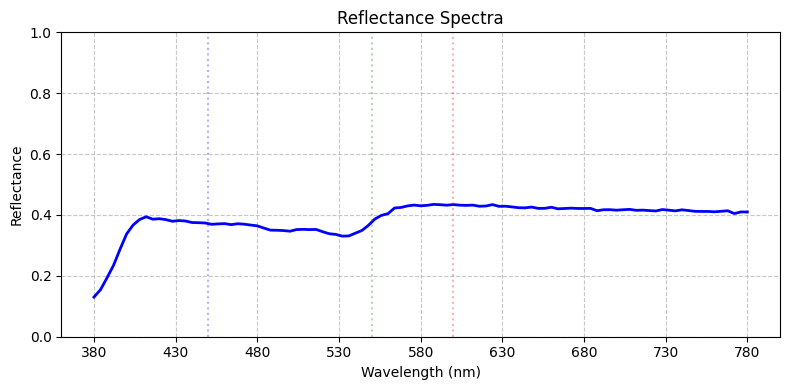

In [6]:
plot_spectrum(reflectance_spectra.T[2], "Reflectance Spectra", "reflectance")

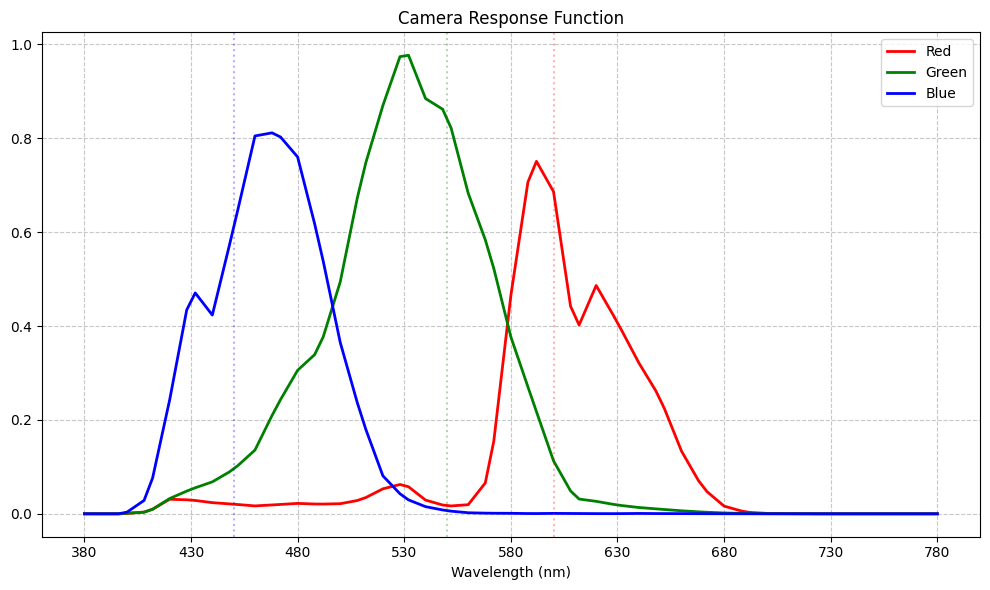

In [7]:
plot_camera_response(camera_response_spectra.T)

In [8]:
illumination_spectra.T.shape

(158, 101)

In [9]:
# get reflectance and illumination bases B_r, B_l

def compute_basis(spectra, method, camera_response, num_components=3):
    """
    compute the basis for the given spectra
    Params:
    spectra: spectra array of shape (N, lambdas) 
    num_components: number of components for reduced space
    method: weighted pca or pca (wpca, pca)
    camera_response: if using weighted pca, then crf is the weight (3,lambdas)
    """
    assert method in ["wpca", "pca"]
    if method == 'wpca':
        assert camera_response is not None
        assert camera_response.shape[0] == 3

    spectra = spectra - spectra.mean(axis=0)
    if method == 'pca':
        # mean centered
        U,S,Vt = np.linalg.svd(spectra, full_matrices=False)
        Basis = Vt.T[:, :num_components]

    else:
        # weighted PCA method from the paper
        # TODO: in the paper, there is no mention of spectra being centered
        # so check if this gives us the same result, probably should
        R = []
        for i in range(3):
            R_scaled = spectra @ np.diag(camera_response[i])
            _, _, Vt = np.linalg.svd(R_scaled, full_matrices=False)
            R.append(Vt.T[:, :1])

        R = np.hstack(R)
        Basis, _ = np.linalg.qr(R)
        
    return Basis
        
        


In [10]:
B_r = compute_basis(reflectance_spectra.T, "wpca", camera_response_spectra.T)
B_l = compute_basis(illumination_spectra.T, "wpca", camera_response_spectra.T)

In [11]:
print(B_r.shape , B_l.shape, camera_response_spectra.shape)

(101, 3) (101, 3) (101, 3)


In [12]:
# compute reflectance coefficients

#first compute flash spectra
flash_light = 0.025 * np.ones(101)
f = B_l.T @ flash_light
f = f / np.linalg.norm(f)


In [13]:
M1 = 3
M2 = 3
k = 3
E = np.empty((k, M1, M2)) # 3 channels x M1 x M2
for i in range(k):
    E[i, :, :] = B_r.T @ np.diag(camera_response_spectra[:, i]) @ B_l
print(E.shape)


(3, 3, 3)


/Users/ayank/.pyenv/versions/3.10.11/envs/pgpt/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


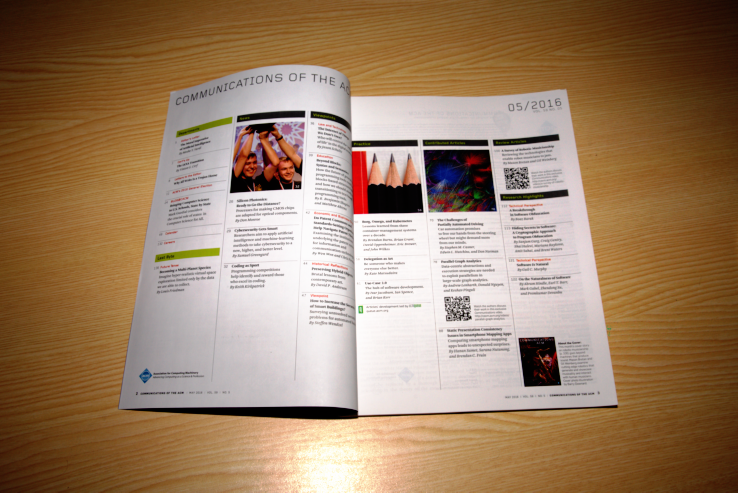

In [14]:
# pure flash image
pf = (two_lights['im_f'] - two_lights['im_nf']) * two_lights['mask'][:,:, np.newaxis]
display_img(pf, hist_equalize=True)

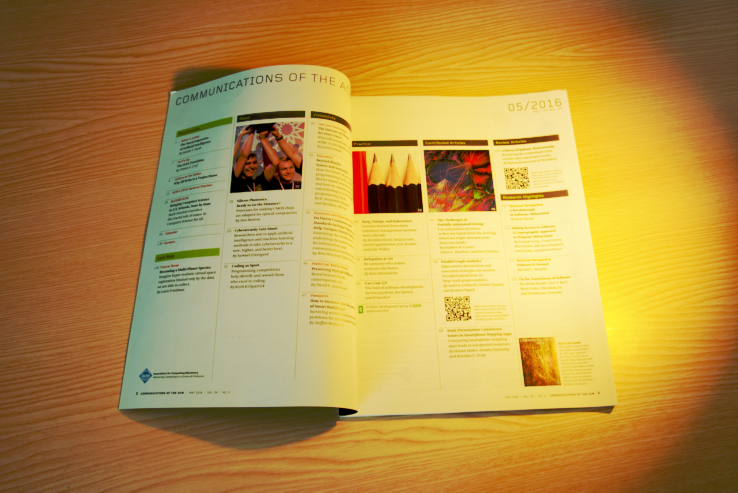

In [15]:
display_img(two_lights['im_nf'], hist_equalize=True)

In [16]:
H,W,C = pf.shape
Amat = np.zeros((3, 3))
Amat[:, 0] = E[0, :, :] @ f  # Matrix-vector multiplication for the first column
Amat[:, 1] = E[1, :, :] @ f  # Matrix-vector multiplication for the second column
Amat[:, 2] = E[2, :, :] @ f  # Matrix-vector multiplication for the third column

# Reshape diff_img and im_nf to 3x(N), where N is the number of pixels
diff_img_vec = pf.reshape(-1, 3).T

# Get the alpha image using matrix division
alpha_img = np.linalg.solve(Amat.T, diff_img_vec)

alpha_img = alpha_img.T.reshape(H, W, 3)

# Compute the norm of alpha for each pixel
alpha_norm = np.linalg.norm(alpha_img, axis=2, keepdims=True)

# Avoid division by zero by replacing zeros in the norm with a small value
alpha_norm[alpha_norm == 0] = 1e-6

# Compute the normalized alpha image
alpha_norm_img = alpha_img / alpha_norm

# get reflectance image by integrating with the Basis and camera response function
reflectance_img = ((alpha_norm_img.reshape(-1, 3) @ B_r.T) @ camera_response_spectra).reshape(H, W, C)


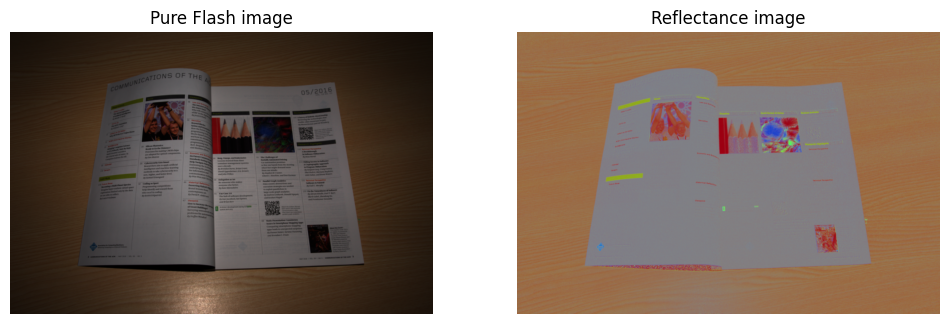

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].imshow(to_8bit(pf))
axes[0].set_title("Pure Flash image")
axes[0].axis('off')
axes[1].imshow(to_8bit(reflectance_img))
axes[1].set_title("Reflectance image")
axes[1].axis('off')
plt.show()

/Users/ayank/.pyenv/versions/3.10.11/envs/pgpt/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


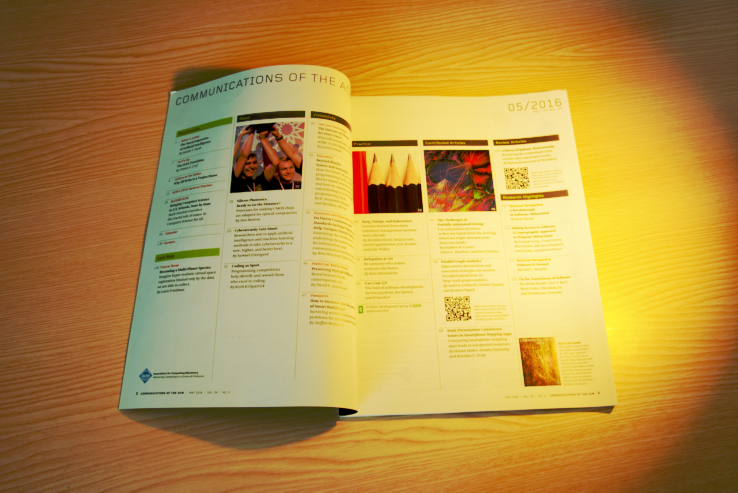

In [20]:
nf = two_lights['im_nf']
display_img( nf, hist_equalize=True)

In [19]:
from sklearn.linear_model import Ridge


In [33]:
# B_mat_0 = np.zeros((H*W, 3))
alpha_norm_vec = alpha_norm_img.reshape(-1, 3) 
nf_img_vec = nf.reshape(-1, 3)

Beta_p = np.zeros((H*W, 3))
for i in range(H*W):
    # ridge_reg = Ridge(alpha=1e-5, fit_intercept=False)
    _B_i = (alpha_norm_vec[i] @ E)
    _I_i = nf_img_vec[i]
    # ridge_reg.fit(_B_i, _I_i)
    # Beta_p[i, :] = ridge_reg.coef_.flatten()
    _beta_p = np.linalg.solve(_B_i, _I_i)
    Beta_p[i, :] = _beta_p


In [34]:
Beta_img = Beta_p.reshape(H, W, 3)
Beta_norm = np.linalg.norm(Beta_img, axis=2, keepdims=True)
Beta_norm += 1e-10


In [35]:
gamma = Beta_img / Beta_norm

/Users/ayank/.pyenv/versions/3.10.11/envs/pgpt/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


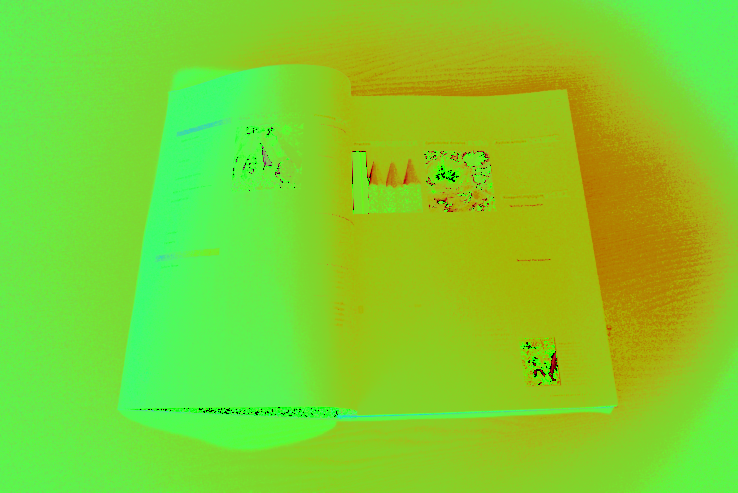

In [103]:
illumination_img = ((gamma.reshape(-1, 3) @ B_l.T) @ camera_response_spectra).reshape(H, W, C)
display_img(illumination_img, hist_equalize=True)

In [80]:
# might need an extra step of filtering on the illumination image

In [130]:
# estimate 2 light coefficient
mask = two_lights['mask']
M = 2
pts = gamma[(mask>0), :]
inlier_angle = .3*np.pi/180 # 0.3 degrees in radians
iter = 1000
cfactor = 0.1

In [143]:
np.random.permutation(pts.shape[0])[:2]

array([346441, 335705])

In [ ]:
max_inliers = 0
n0_max = None
for i in iter:
    f
    